# Data generation - 2D image geometries

This tutorial demonstrates data generation with 2D images as geometry parameterization. We create a set of dielectric nanostructures, their top-view images are representing the geometry. We calculate the optical scattering spectra.

Due to the slow speed of the simulations, we also provide a pre-calcuated version of the dataset with 16000 scattering spectra.


## Install (colab) and import modules

In [1]:
import time

import numpy as np
import PyMoosh.core as pym
import matplotlib.pyplot as plt
import h5py

from pyGDM2 import core
from pyGDM2 import tools
from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import propagators
from pyGDM2 import fields
from pyGDM2 import linear

# use pyGDM2's optimization module for random structure generation
from pyGDM2.EO import models as eo_models

## random generator limits and simulation config

In [2]:
lim_N_block = [2, 3]  # number of dielectric blocks
lim_L = [3, 8]        # length limits
lim_W = [3, 8]        # width limits
height = 5            # block height
lim_pos = [-5, 5]     # position limits (all in units of step)

print("Area max X =", -lim_pos[0]+lim_pos[1]+lim_W[1]+1,
      "; Area max Y =", -lim_pos[0]+lim_pos[1]+lim_L[1]+1)

N_index = 5
N_models_per_index = 5
N_wavelength = 50

print("total nr of data: {}x{}={}  (x{} wl)".format(
    N_index, N_models_per_index, N_index*N_models_per_index, N_wavelength))

# ==============================================================================
# Setup pyGDM part
# ==============================================================================
method = 'cupy'

# initialize dummy geometry (required for the EO module)
step = 30   # nm
material = materials.dummy(3.5)  # ideal dielectric
geometry_init = []
struct_init = structures.struct(step, geometry_init, material)

# Setup incident field
field_generator = fields.planewave
kwargs = dict(theta=[0.0, 90])
wavelengths = np.linspace(500.0, 1000.0, N_wavelength)
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)

# environment - vacuum
dyads = propagators.DyadsQuasistatic123(1)

# simulation instance
sim_init = core.simulation(struct_init, efield, dyads)

Area max X = 19 ; Area max Y = 19
total nr of data: 5x5=25  (x50 wl)
structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 0/0 dipoles valid


/home/pwiecha/.local/lib/python3.10/site-packages/pyGDM2/tools.py:971: UserWarning: Empty structure. Setting mesh to 'cubic'.
  warnings.warn("Empty structure. Setting mesh to 'cubic'.")
/home/pwiecha/.local/lib/python3.10/site-packages/pyGDM2/structures.py:190: UserWarning: Emtpy structure geometry.
  warnings.warn("Emtpy structure geometry.")
/home/pwiecha/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/pwiecha/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


## Loop to generate and simulate random geometries

In [3]:

all_geo = []
all_spec0 = []
all_spec90 = []
for i in range(N_index):
    # use eo-model for simple random structure generation
    model = eo_models.MultiRectAntenna(
        sim_init, N_antennas=np.random.randint(
                        lim_N_block[0], lim_N_block[1]+1), 
        limits_W=lim_W, limits_L=lim_L, 
        limits_pos_x=lim_pos, limits_pos_y=lim_pos, 
        height=height)  # units of step

    print("batch {} / {}".format(i, N_index))
    for j in range(N_models_per_index):
        model.random_structure()
        print('N_dp =', len(model.sim.struct.geometry), end='\r')

        # do the simulation
        model.sim.scatter(method=method, verbose=0)

        # calculate extinction / scattering spectra for X/Y polarization
        wl, spec_ext0 = tools.calculate_spectrum(model.sim, 0, linear.extinct)
        wl, spec_ext90 = tools.calculate_spectrum(model.sim, 1, linear.extinct)

        # create topview image, 20x20 steps large
        img_struct = structures.struct_to_image(model.sim, minimum_size=20)

        # add results to lists
        all_spec0.append(spec_ext0[:, 1])   # keep scattering
        all_spec90.append(spec_ext90[:, 1])  # keep scattering
        all_geo.append(img_struct[..., 0])

# convert to numpy
all_geo = np.array(all_geo)[..., None]  # add empty channels dimension

all_spec0 = np.array(all_spec0)
all_spec90 = np.array(all_spec90)
all_spec = np.stack([all_spec0, all_spec90], axis=-1)

batch 0 / 5
batch 1 / 5
batch 2 / 5
batch 3 / 5
batch 4 / 5


## Plot example

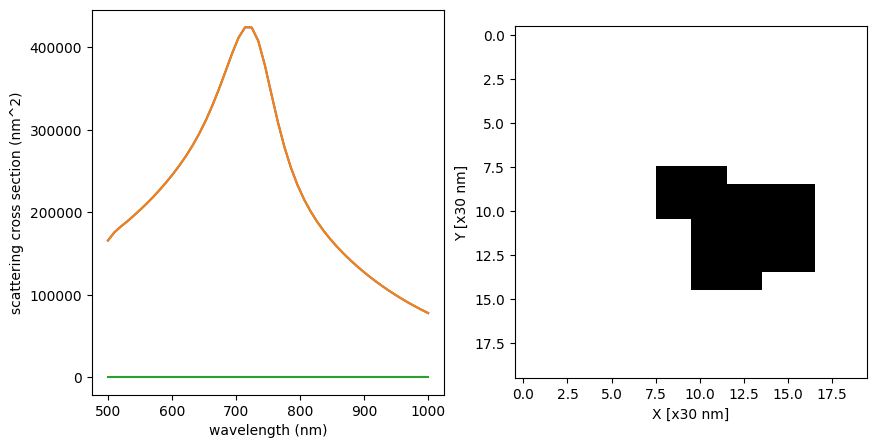

In [4]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(wl, spec_ext0)
plt.xlabel('wavelength (nm)')
plt.ylabel('scattering cross section (nm^2)')

plt.subplot(122)
plt.imshow(img_struct)
plt.xlabel('X [x30 nm]')
plt.ylabel('Y [x30 nm]')
plt.show()

## save to hdf5

In [5]:
with h5py.File('datasets/dataset3_nanoscat.h5', "w") as f:
    COMPR = 'lzf'   # very fast compression
    dset = f.create_dataset("geo2d", data=all_geo,
                            dtype=np.float32, compression=COMPR)
    dset = f.create_dataset("scatspec", data=all_spec,
                            dtype=np.float32, compression=COMPR)